# Step 1: Install Necessary Libraries

In [ ]:
# # Restart the runtime
# import os
# os.kill(os.getpid(), 9)

In [ ]:
# Update and install system dependencies
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev

# Upgrade pip and install/upgrade Python packages
!pip install --upgrade pip setuptools wheel

# Install/upgrade main libraries
!pip install --upgrade gymnasium
!pip install stable-baselines3==2.2.1
!pip install shimmy==1.3.0
!pip install pytesseract

# Install transformers and related libraries
!pip install transformers datasets seqeval

# Install LayoutParser with OCR support
!pip install "layoutparser[ocr]"

# Install Detectron2
!pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

# Install PyTorch Lightning
!pip install pytorch-lightning

# Upgrade Accelerate and Transformers
!pip install accelerate -U
!pip install transformers[torch] --upgrade

# Check installed packages
!pip list

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,626 B in 1s (2,517 B/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.31.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
antlr4-python3-runtime           4.9.3
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bind

# Step 2: Import Libraries

In [ ]:
import torch
from transformers import  (LayoutLMv3Processor, LayoutLMv3ForTokenClassification,
                           TrainingArguments, Trainer, DataCollatorForTokenClassification,
                           EarlyStoppingCallback, TrainerCallback)
from datasets import load_dataset, load_metric
import pytorch_lightning as pl
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage
from seqeval.metrics import classification_report, accuracy_score
import gymnasium as gym
from gymnasium import spaces
import pytesseract
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, BaseCallback
from google.colab import files
import os
import shutil

# Set the Tesseract command path
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Step 3: Load and Preprocess the FUNSD Dataset

In [ ]:
# Load the FUNSD dataset
dataset = load_dataset("nielsr/funsd", trust_remote_code=True)

# Initialize the processor with apply_ocr set to False
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

# Preprocess the dataset
def preprocess_data(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']

    encoded_inputs = processor(
        images=images,
        text=words,
        boxes=boxes,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Add labels
    encoded_inputs["labels"] = examples["ner_tags"]

    return encoded_inputs

# Apply preprocessing to the dataset
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset["train"].column_names)

print("Dataset preprocessing completed.")
print(encoded_dataset["train"].features)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Dataset preprocessing completed.
{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'bbox': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


# Step 4: Fine-Tune the LayoutLMv3 Model

In [ ]:
# Define the id2label dictionary
id2label = {
    0: "O",
    1: "B-HEADER",
    2: "I-HEADER",
    3: "B-QUESTION",
    4: "I-QUESTION",
    5: "B-ANSWER",
    6: "I-ANSWER"
}

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[label] for label in label_seq if label != -100] for label_seq in labels]
    true_predictions = [[id2label[pred] for (pred, label) in zip(pred_seq, label_seq) if label != -100]
                        for pred_seq, label_seq in zip(predictions, labels)]

    results = classification_report(true_labels, true_predictions, output_dict=True)
    return {
        "precision": results["micro avg"]["precision"],
        "recall": results["micro avg"]["recall"],
        "f1": results["micro avg"]["f1-score"],
    }

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,1.664500,1.656715,0.091302,0.073522,0.081453,0.326756


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


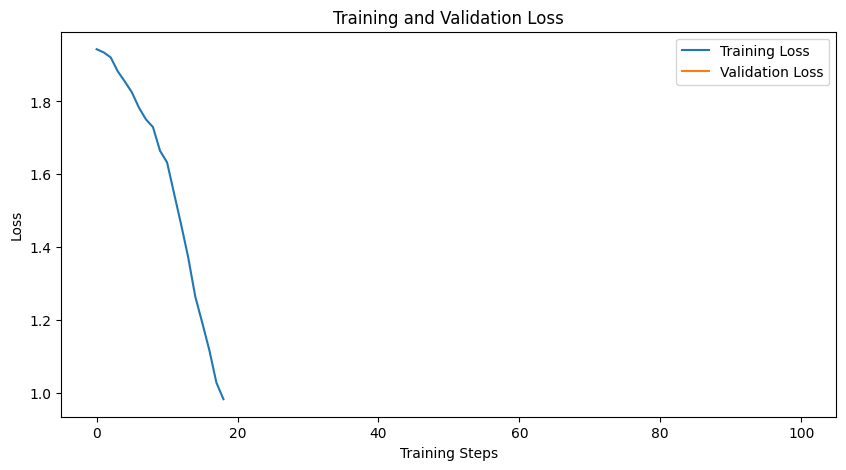

Model training completed. Saving the model...
Model saved. Preparing for download...
Model prepared for download. Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated. Please check your downloads folder.
To use this model in future sessions, upload the zip file and extract it to './finetuned_layoutlmv3'
Setup complete.


In [ ]:
# Define the model
NUM_LABELS = len(dataset["train"].features["ner_tags"].feature.names)
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=NUM_LABELS)

# Preprocess function
def preprocess_data(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples['words']
    boxes = examples['bboxes']
    word_labels = examples['ner_tags']

    encoded_inputs = processor(
        images,
        words,
        boxes=boxes,
        word_labels=word_labels,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return {
        'input_ids': encoded_inputs['input_ids'].squeeze(),
        'attention_mask': encoded_inputs['attention_mask'].squeeze(),
        'bbox': encoded_inputs['bbox'].squeeze(),
        'pixel_values': encoded_inputs['pixel_values'].squeeze(),
        'labels': encoded_inputs['labels'].squeeze()
    }

# Preprocess the dataset
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset["train"].column_names)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,
    learning_rate=1e-5,
    per_device_train_batch_size=4,  # Adjust based on your GPU memory
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
    gradient_accumulation_steps=2,
    warmup_steps=500,
)

# Create a data collator
data_collator = DataCollatorForTokenClassification(processor.tokenizer, padding=True, max_length=512)

class PlotLossCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        self.train_losses = []
        self.eval_losses = []
        self.eval_steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.train_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_losses.append(logs["eval_loss"])
            self.eval_steps.append(state.global_step)

    def on_train_end(self, args, state, control, **kwargs):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_steps, self.eval_losses, label='Validation Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

# Create callbacks
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)
plot_loss_callback = PlotLossCallback()

# Define label list
label_list = dataset["train"].features["ner_tags"].feature.names

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]

    results = classification_report(true_labels, true_predictions, output_dict=True)
    return {
        "precision": results["micro avg"]["precision"],
        "recall": results["micro avg"]["recall"],
        "f1": results["micro avg"]["f1-score"],
        "accuracy": accuracy_score(sum(true_labels, []), sum(true_predictions, []))
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, plot_loss_callback]
)

# Train the model
trainer.train()

# The learning curve will be displayed after training

print("Model training completed. Saving the model...")

# Save the fine-tuned model
model_save_path = "./finetuned_layoutlmv3"
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)

print("Model saved. Preparing for download...")

# Create a zip file of the model directory
shutil.make_archive("finetuned_layoutlmv3", 'zip', model_save_path)

print("Model prepared for download. Initiating download...")
# Download the zip file
files.download("finetuned_layoutlmv3.zip")

print("Download initiated. Please check your downloads folder.")
print("To use this model in future sessions, upload the zip file and extract it to './finetuned_layoutlmv3'")

# Optional: Clean up the zip file to save space
os.remove("finetuned_layoutlmv3.zip")

print("Setup complete.")

In [ ]:
# Create a zip file of the model directory
shutil.make_archive("finetuned_layoutlmv3", 'zip', model_save_path)

print("Model prepared for download. Initiating download...")
# Download the zip file
files.download("finetuned_layoutlmv3.zip")

Model prepared for download. Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 5: Apply Reinforcement Learning to Improve the Model

In [ ]:
class InvoiceEnv(gym.Env):
    def __init__(self, dataset, model, processor):
        super(InvoiceEnv, self).__init__()
        self.dataset = dataset["test"]
        self.model = model
        self.processor = processor
        self.current_index = 0
        self.max_index = len(self.dataset) - 1
        self.episode_count = 0

        self.action_space = spaces.Discrete(2)  # 0 = skip, 1 = process
        self.observation_space = spaces.Box(low=0, high=255, shape=(224, 224, 3), dtype=np.uint8)
        print(f"Environment initialized with {self.max_index + 1} samples.")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_index = 0
        self.episode_count += 1
        observation = self._get_observation()
        info = {}
        print(f"Episode {self.episode_count} started.")
        return observation, info

    def step(self, action):
        if action == 1:  # Process the invoice
            sample = self.dataset[self.current_index]
            image = Image.open(sample["image_path"]).convert("RGB")
            words = sample["words"]
            boxes = sample["bboxes"]

            encoded_inputs = self.processor(
                image,
                words,
                boxes=boxes,
                return_tensors="pt",
                padding="max_length",
                truncation=True
            )

            with torch.no_grad():
                outputs = self.model(**encoded_inputs)
            predictions = outputs.logits.argmax(-1).squeeze().tolist()
            reward = self.calculate_reward(predictions, sample["ner_tags"])
            print(f"Processed invoice {self.current_index}. Reward: {reward}")
        else:  # Skip the invoice
            reward = 0
            print(f"Skipped invoice {self.current_index}. Reward: {reward}")

        self.current_index += 1
        done = self.current_index > self.max_index
        truncated = False

        if done:
            print(f"Episode {self.episode_count} completed.")
            self.current_index = 0  # Reset to the beginning if we've reached the end

        observation = self._get_observation()
        info = {}

        return observation, reward, done, truncated, info

    def _get_observation(self):
        sample = self.dataset[self.current_index]
        image = Image.open(sample["image_path"]).convert("RGB")
        image = image.resize((224, 224))  # Resize to match observation space
        return np.array(image)

    def calculate_reward(self, predictions, true_labels):
        correct = sum(p == t for p, t in zip(predictions, true_labels))
        total = len(true_labels)
        accuracy = correct / total
        return accuracy

# Step 6: Define the Agent and Training Loop

In [ ]:
class ProgressPrintCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ProgressPrintCallback, self).__init__(verbose)
        self.progress_interval = 1000  # Print every 1000 steps

    def _on_step(self) -> bool:
        if self.n_calls % self.progress_interval == 0:
            print(f"Training progress: {self.n_calls}/{self.locals['total_timesteps']} steps completed")
            print(f"Episode reward: {self.locals['rewards'][0]}")
            print(f"Episode length: {self.locals['dones'][0]}")
            print("---")
        return True

In [ ]:
# Load the fine-tuned model and processor
print("Loading the fine-tuned model and processor...")
model = LayoutLMv3ForTokenClassification.from_pretrained("./finetuned_layoutlmv3")
processor = LayoutLMv3Processor.from_pretrained("./finetuned_layoutlmv3")
print("Model and processor loaded successfully.")

# Load the FUNSD dataset
print("Loading the FUNSD dataset...")
dataset = load_dataset("nielsr/funsd", trust_remote_code=True)
print("Dataset loaded successfully.")

# Create the environment
print("Creating the environments...")
env = DummyVecEnv([lambda: InvoiceEnv(dataset, model, processor)])
env = VecTransposeImage(env)  # Add this line to wrap the env consistently

eval_env = DummyVecEnv([lambda: InvoiceEnv(dataset, model, processor)])
eval_env = VecTransposeImage(eval_env)  # Add this line for consistency
print("Environments created successfully.")

# Create the RL agent
print("Creating the RL agent...")
rl_agent = PPO("CnnPolicy", env, verbose=1, tensorboard_log="./ppo_invoice_tensorboard/")
print("RL agent created successfully.")

# Create callbacks
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=5, min_evals=5, verbose=1)
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model/",
    log_path="./logs/",
    eval_freq=500,
    deterministic=True,
    render=False,
    callback_after_eval=stop_train_callback
)

print("Starting the training process...")
rl_agent.learn(
    total_timesteps=20000,
    callback=eval_callback,
    log_interval=100
)
print("Training completed.")

# Save the final model
rl_agent.save("final_layoutlmv3_rl_agent")
print("Final agent saved successfully.")

Loading the fine-tuned model and processor...
Model and processor loaded successfully.
Loading the FUNSD dataset...
Dataset loaded successfully.
Creating the environments...
Environment initialized with 50 samples.
Environment initialized with 50 samples.
Environments created successfully.
Creating the RL agent...
Using cuda device
RL agent created successfully.
Starting the training process...
Episode 1 started.
Logging to ./ppo_invoice_tensorboard/PPO_1


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Processed invoice 0. Reward: 0.5022421524663677
Skipped invoice 1. Reward: 0
Processed invoice 2. Reward: 0.5093457943925234
Skipped invoice 3. Reward: 0
Processed invoice 4. Reward: 0.16666666666666666
Processed invoice 5. Reward: 0.4919786096256685
Skipped invoice 6. Reward: 0
Skipped invoice 7. Reward: 0
Processed invoice 8. Reward: 0.20689655172413793
Processed invoice 9. Reward: 0.14285714285714285
Processed invoice 10. Reward: 0.23809523809523808
Processed invoice 11. Reward: 0.17894736842105263
Processed invoice 12. Reward: 0.21481481481481482
Processed invoice 13. Reward: 0.3482142857142857
Skipped invoice 14. Reward: 0
Skipped invoice 15. Reward: 0
Processed invoice 16. Reward: 0.27424749163879597
Skipped invoice 17. Reward: 0
Skipped invoice 18. Reward: 0
Processed invoice 19. Reward: 0.2127659574468085
Skipped invoice 20. Reward: 0
Processed invoice 21. Reward: 0.3347457627118644
Skipped invoice 22. Reward: 0
Processed invoice 23. Reward: 0.2653061224489796
Processed invoice

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Skipped invoice 7. Reward: 0
Skipped invoice 8. Reward: 0
Skipped invoice 9. Reward: 0
Skipped invoice 10. Reward: 0
Skipped invoice 11. Reward: 0
Skipped invoice 12. Reward: 0
Skipped invoice 13. Reward: 0
Skipped invoice 14. Reward: 0
Skipped invoice 15. Reward: 0
Skipped invoice 16. Reward: 0
Skipped invoice 17. Reward: 0
Processed invoice 18. Reward: 0.18421052631578946
Skipped invoice 19. Reward: 0
Skipped invoice 20. Reward: 0
Skipped invoice 21. Reward: 0
Skipped invoice 22. Reward: 0
Skipped invoice 23. Reward: 0
Skipped invoice 24. Reward: 0
Skipped invoice 25. Reward: 0
Skipped invoice 26. Reward: 0
Skipped invoice 27. Reward: 0
Skipped invoice 28. Reward: 0
Skipped invoice 29. Reward: 0
Skipped invoice 30. Reward: 0
Skipped invoice 31. Reward: 0
Skipped invoice 32. Reward: 0
Skipped invoice 33. Reward: 0
Skipped invoice 34. Reward: 0
Skipped invoice 35. Reward: 0
Skipped invoice 36. Reward: 0
Skipped invoice 37. Reward: 0
Skipped invoice 38. Reward: 0
Skipped invoice 39. Rew

KeyboardInterrupt: 

# Step 7: Test the Model on a Custom Invoice Image

In [ ]:
# Load the fine-tuned model and processor
model = LayoutLMv3ForTokenClassification.from_pretrained("./finetuned_layoutlmv3")
processor = LayoutLMv3Processor.from_pretrained("./finetuned_layoutlmv3")

# Load the RL agent
rl_agent = PPO.load("layoutlmv3_rl_agent")

# Upload and preprocess the custom invoice image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")
encoded_inputs = processor(image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**encoded_inputs)

# Process the outputs
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()
id2label = model.config.id2label

# Group tokens into elements and assign labels
elements = []
current_element = {"box": None, "class": None, "text": "", "confidence": 0}

for token, box, label_id in zip(encoded_inputs.input_ids.squeeze().tolist(), token_boxes, predictions):
    if token == processor.tokenizer.sep_token_id:
        if current_element["box"]:
            elements.append(current_element)
        current_element = {"box": None, "class": None, "text": "", "confidence": 0}
    else:
        if not current_element["box"]:
            current_element["box"] = box
            current_element["class"] = id2label[label_id]
        current_element["text"] += processor.tokenizer.decode([token])
        current_element["confidence"] = max(current_element["confidence"], outputs.logits.softmax(-1).max().item())

if current_element["box"]:
    elements.append(current_element)

# Visualize the results
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for element in elements:
    x, y, w, h = element["box"]
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, element["class"], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

plt.figure(figsize=(12,16))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm import tqdm
import shutil

# Replace these with your actual file paths
source_path = '/content/finetuned_layoutlmv3.zip'
destination_path = '/content/drive/My Drive/finetuned_layoutlmv3.zip'

shutil.copy(source_path, destination_path)

def copy_with_progress(src, dst, chunk_size=16*1024):
    file_size = os.path.getsize(src)
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
        with tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Copying {src} to {dst}") as pbar:
            while True:
                chunk = fsrc.read(chunk_size)
                if not chunk:
                    break
                fdst.write(chunk)
                pbar.update(len(chunk))

# Use the function
copy_with_progress(source_path, destination_path)


Copying /content/finetuned_layoutlmv3.zip to /content/drive/My Drive/finetuned_layoutlmv3.zip: 100%|██████████| 467M/467M [00:04<00:00, 108MB/s]
